# Neural Networks for Data Science Applications
## Saliency maps for interpretability

**Name**: *Francesco Pinto*

**Matricola**: *1871045*


In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from google.colab import drive
import random
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers, initializers, regularizers, Model, Input
from tensorflow.keras import losses, metrics, optimizers, callbacks
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 6]
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Overview

Neural networks are powerful tools, but they are **black-boxes**, meaning that it is difficult to provide human-understandable explanations on what they are doing. The field of **explanaibility** is concerned with finding algorithms for achieving this. In this homework, you will be guided in implementing some basic explanaibility algorithms (**saliency maps**), which is an instructive way of playing with the TensorFlow autodiff framework.


## Warmup: Data loading



✍ **DESCRIPTION OF THE CODE**



In [ ]:
train, t_info = tfds.load('plant_village', as_supervised = True, split = 'train[:70%]', with_info = True)
val = tfds.load('plant_village', as_supervised = True, split = 'train[70%:80%]')
test = tfds.load('plant_village', as_supervised = True, split = 'train[80%:]')

I decided to work with "plant_village" dataset from TensorFlow Datasets.

The Dataset is composed by 54303 images of leaves (healthy and unhealthy). It's divided in 38 classes and it's quite unbalanced, as you can see from the table that is two code-lines below.

I haven't reduced the number of classes, so I will perform a multi-class classification task for 38 different classes.

The way I splitted Train, Validation and Test set is the following:

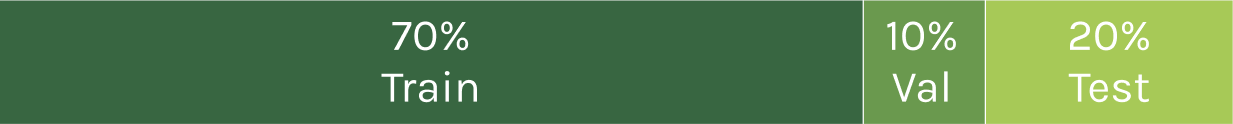

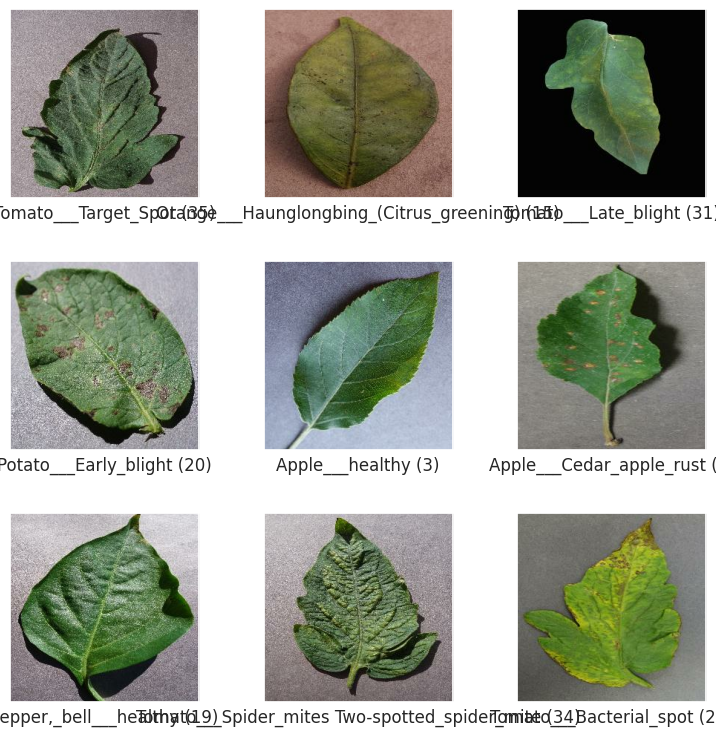

In [ ]:
fig = tfds.show_examples(train, t_info)

Then I check if the train-set is balanced or not.

In [ ]:
classes = t_info.features['label'].names
class_mapping = {name: i for i, name in enumerate(classes)}

vals = np.unique(np.fromiter(train.map(lambda x, y: y), float), return_counts=True)
freq_distr = pd.DataFrame()
freq_distr['Class'], freq_distr['Frequency'] = class_mapping.keys(), vals[1]
freq_distr

,Class,Frequency
0,Apple___Apple_scab,433
1,Apple___Black_rot,403
2,Apple___Cedar_apple_rust,189
3,Apple___healthy,1139
4,Blueberry___healthy,1073
5,Cherry___healthy,569
6,Cherry___Powdery_mildew,752
7,Corn___Cercospora_leaf_spot Gray_leaf_spot,357
8,Corn___Common_rust,835
9,Corn___healthy,832


It's not particularly balanced, some classes have very few examples compared to others.

**Initial Preprocessing**

I scale, cast and crop the image to $100\times 100$.

Then, I cast also the labels in order to avoid some errors happened during training.

In [ ]:
def processing(image, label):
  #Image Croppng
  image = tf.image.resize(image, (100, 100))
  #Casting & Scaling
  image = tf.cast(image, tf.float32) / 255
  #Casting also the labels in order to avoid errors during training
  label = tf.cast(label, tf.float32)
  return image, label

train = train.map(processing).batch(16)
val = val.map(processing).batch(16)
test = test.map(processing)

### Training a DenseNet


**Neural Network Definition: DenseNet-121**

Given that I wanted to perform a multi-class classification with 38 classes, I asked ChatGPT which NN would fit with my problem: it was answered me that a DenseNet can perform a good job for my case.

"*The dense connection between the layers of these networks can facilitate the propagation of information across the layers, aiding in class discrimination even in the presence of many targets.*"

So I decided to implement a DenseNet-121 following what is explained in the paper [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf) step-by-step.

The following images and explanation of the steps are copied from the paper. Citations to the document are indicated as [1].

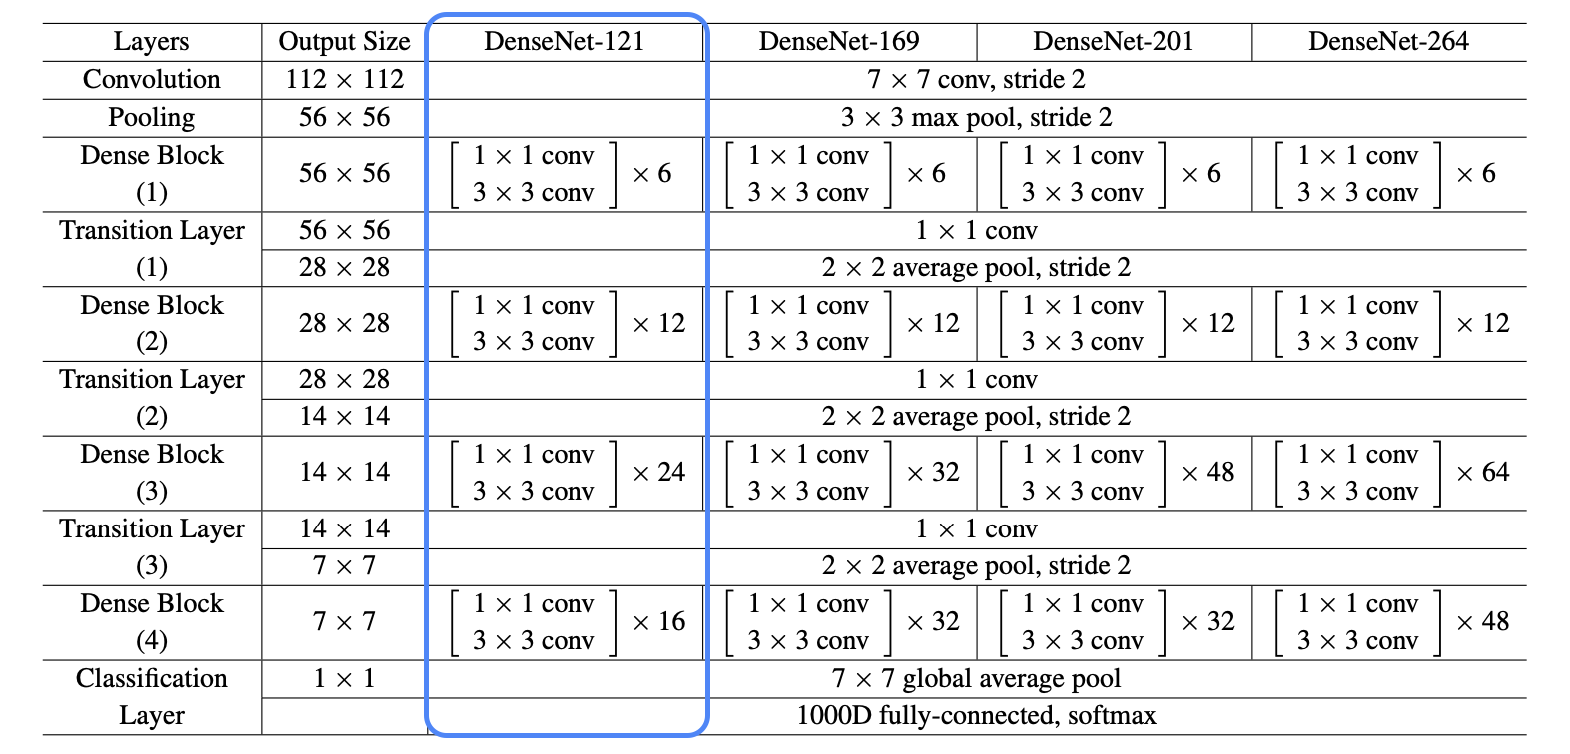

[1] **Composite Function:** we define $H_l(·)$ as a composite function of three consecutive operations: batch normalization (BN), followed by a rectified linear unit (ReLU) and a 3 × 3 convolution (Conv).

This composite function is called *BN-ReLU-Conv*.

In [ ]:
def BN_ReLU_Conv(x, filters, kernel_size = 1, strides = 1):
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters = filters, kernel_size = kernel_size,
                    strides = strides, padding = 'same')(x)
  return x

[1] An essential part of convolutional networks is **down-sampling** layers that change the size of feature-maps.

To facilitate down-sampling in our architecture we divide the network into multiple densely connected **dense blocks**:

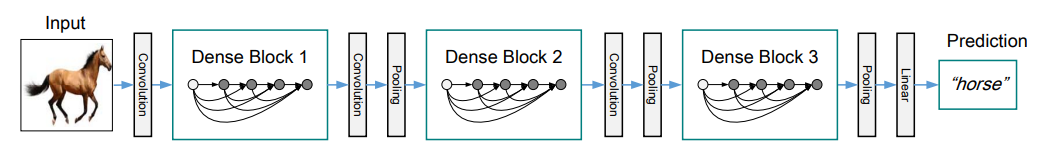

In [ ]:
def DenseBlock(x_0, reps, filters):
  for i in range(reps):
    x = BN_ReLU_Conv(x_0, 4*filters)
    x = BN_ReLU_Conv(x, filters, 3)
    x_0 = layers.Concatenate()([x_0, x])
  return x_0

[1] We refer to layers between blocks as **transition layers**, which do convolution and pooling. The transition layers used in our experiments consist of a batch normalization layer and an 1×1 convolutional layer followed by a 2×2 average pooling layer.

In [ ]:
def TransitionLayer(x):
  x = BN_ReLU_Conv(x, K.int_shape(x)[-1] // 2)
  x = layers.AveragePooling2D(2, strides=2, padding='same')(x)
  return x

In [ ]:
#The following "reps" represent the possible repetitions for any DenseNet
#I will use the DenseNet-121 number of reps
reps_121 = [6, 12, 24, 16]
reps_169 = [6, 12, 32, 32]
reps_201 = [6, 12, 48, 32]
reps_264 = [6, 12, 64, 48]


def DenseNet(repetitions = reps_121):

  n_classes = 38
  inp = layers.Input(shape = (100, 100, 3))

  #Convolution
  #I assume that the cited "growth rate k = 32" in the paper is to be intended as the initial number of filters to use
  x = layers.Conv2D(filters = 32, kernel_size = 7, strides = 2, padding = 'same')(inp)

  #Pooling
  x = layers.MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same')(x)


  for i in range(4):

    x = DenseBlock(x, repetitions[i], 32)
    if i < 3:
      #Given that after the 4th dense block there is no transition layer,
      #we don't compute the 4th transition layer
      x = TransitionLayer(x)

  #Classification Layer
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(n_classes, activation = 'softmax')(x)

  model = Model(inputs=inp, outputs=x)
  return model

model = DenseNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 50, 32)           4736      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 25, 25, 32)           128       ['max_pooling2d[0][0]']   

**Training the Neural Network**

For my task I decided to use *Adam* optimizer, *Categorical Cross-Entropy* as loss function, and *Accuracy* as metric.

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
performance = model.fit(train, epochs=15, validation_data = val)

Epoch 1/15
2376/2376 [==============================] - 390s 111ms/step - loss: 1.3039 - accuracy: 0.6258 - val_loss: 0.9104 - val_accuracy: 0.7090
Epoch 2/15
2376/2376 [==============================] - 255s 107ms/step - loss: 0.5937 - accuracy: 0.8130 - val_loss: 1.0029 - val_accuracy: 0.7225
Epoch 3/15
2376/2376 [==============================] - 254s 107ms/step - loss: 0.3979 - accuracy: 0.8709 - val_loss: 1.5467 - val_accuracy: 0.6584
Epoch 4/15
2376/2376 [==============================] - 265s 111ms/step - loss: 0.2923 - accuracy: 0.9036 - val_loss: 0.8367 - val_accuracy: 0.7840
Epoch 5/15
2376/2376 [==============================] - 259s 109ms/step - loss: 0.2241 - accuracy: 0.9281 - val_loss: 0.4986 - val_accuracy: 0.8617
Epoch 6/15
2376/2376 [==============================] - 264s 111ms/step - loss: 0.1776 - accuracy: 0.9420 - val_loss: 0.5509 - val_accuracy: 0.8790
Epoch 7/15
2376/2376 [==============================] - 265s 111ms/step - loss: 0.1465 - accuracy: 0.9518 - val_

**Testing the Neural Network**

First, let's observe the performance during training.

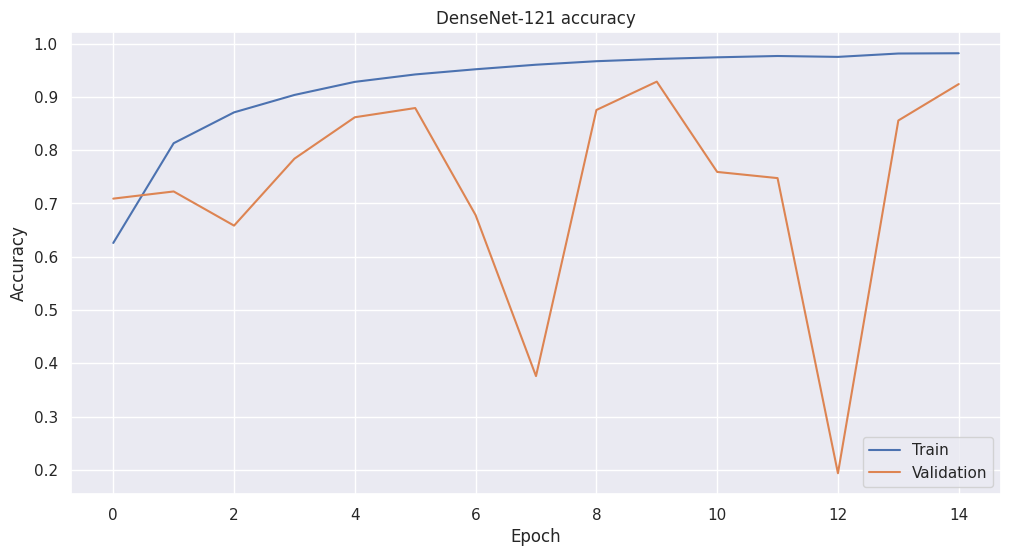

In [ ]:
plt.plot(performance.history['accuracy'])
plt.plot(performance.history['val_accuracy'])
plt.title('DenseNet-121 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

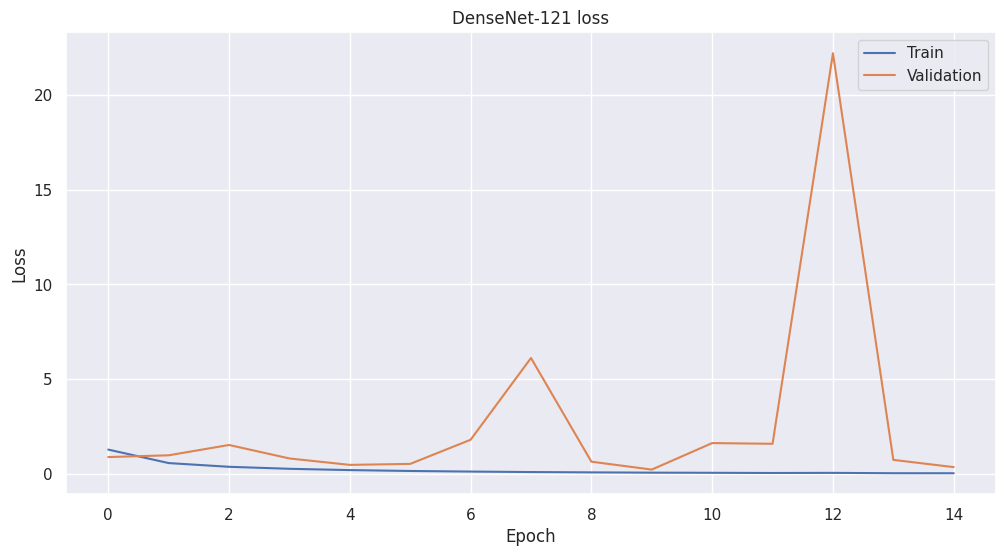

In [ ]:
plt.plot(performance.history['loss'])
plt.plot(performance.history['val_loss'])
plt.title('DenseNet-121 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

The spikes that we see in the plots are a consequence of MiniBatch Gradient Descent. Some MiniBatches receive "unlucky" data for the optimization, causing the "explosions" that we see above.

**Test on test-set**

*Accuracy and Loss*

The accuracy on test set is $92.15\%$ and the loss is $0.3607$, a very good result.

In [ ]:
model.evaluate(test.batch(16))

679/679 [==============================] - 31s 30ms/step - loss: 0.3607 - accuracy: 0.9215


[0.36066243052482605, 0.9214621186256409]

*Confusion Matrix*

Given the large amount of classes, I decided to not put the names in the confusion matrix; it would cause disorder.

We can observe that the model has high performance for almost every class. We can only observe three relevant misclassification problems: class 35 (Tomato Target Spot) has been confused with class 33 (Tomato Septoria leaf spot) and 34 (Tomato Spider mites Two).

Also class 2 (Apple Black rot) has been misclassified more than half of the times, probably because it's the less frequent class, so the NN didn't learn how to well classify it.

By the way, it seems quite a good result.

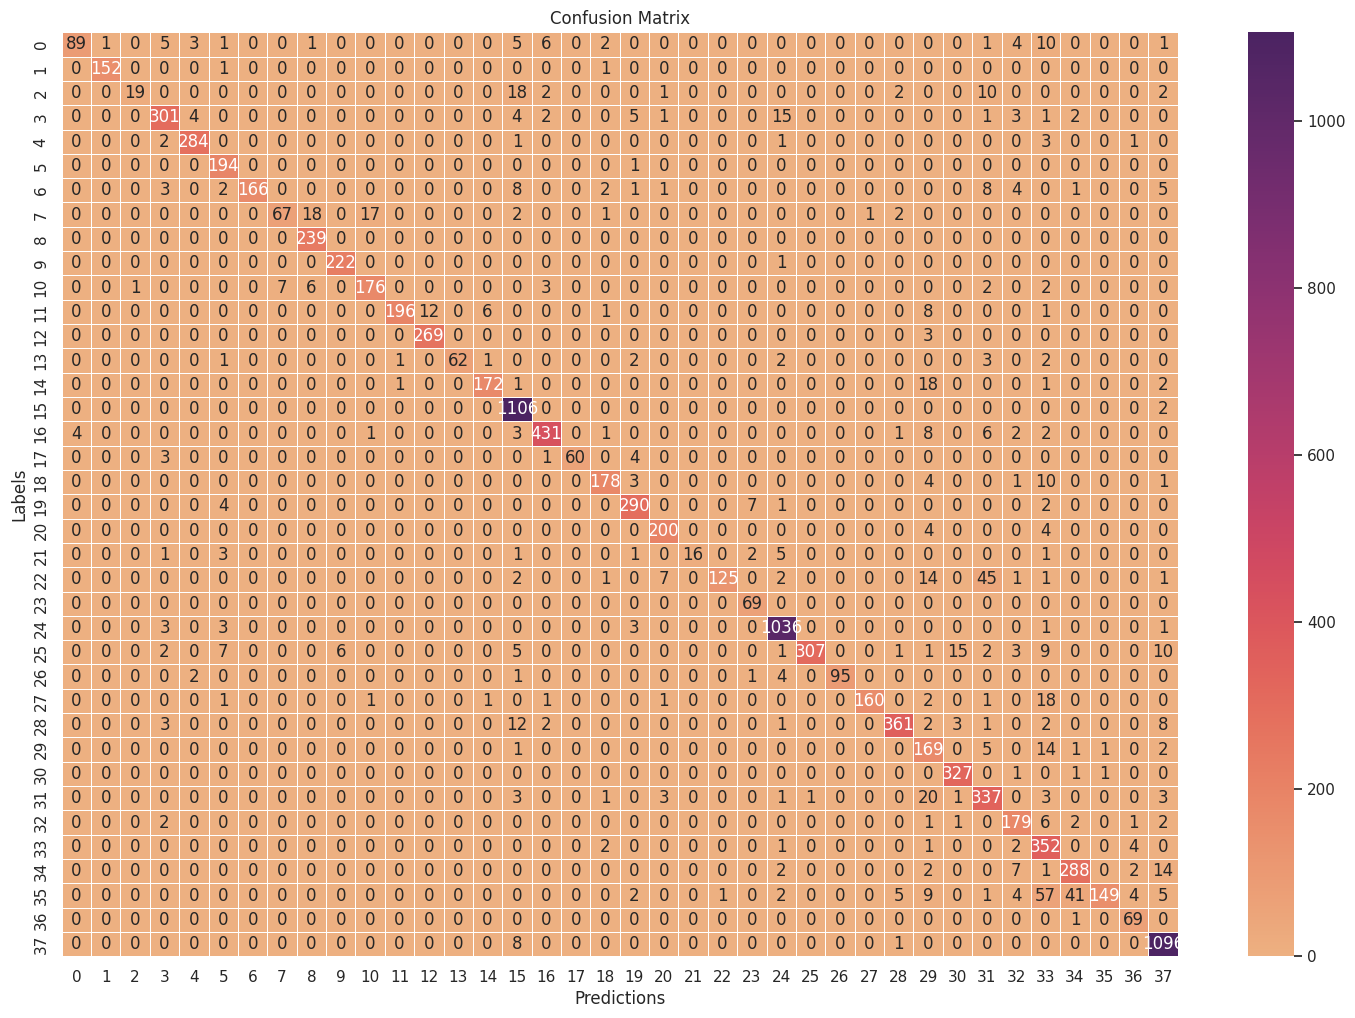

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]

y_pred = model.predict(test.batch(16), batch_size=16)
predictions = tf.math.argmax(y_pred, 1)
y_true = np.concatenate([y for x,y in test.batch(16)], axis=0)

classes = list(class_mapping.values())
confusion_matrix = tf.math.confusion_matrix(y_true, predictions)
confusion_matrix = pd.DataFrame(confusion_matrix, index = classes, columns = classes)

sns.heatmap(confusion_matrix, annot=True,linewidth= 0.5, cmap = "flare", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Labels')
plt.xlabel('Predictions')
plt.show()

###  Computing a vanilla saliency map

What do we mean by explainability? Consider the neural network $f(\cdot)$ you just trained, and a prediction $\hat{y} = f(x)$ we want to analyze. **Feature attribution** methods try to assign a weight $w_i$ to each input feature $x_i$, to understand which parts of the input have contributed the most to the explanation.

The simplest feature attribution technique, called **vanilla saliency map**, simply computes the gradient at that point:

$$
  S(x) = \left\lvert \frac{\partial f_c(x)}{\partial x} \right\rvert
$$

where  $c$ is the index corresponding to the predicted class.



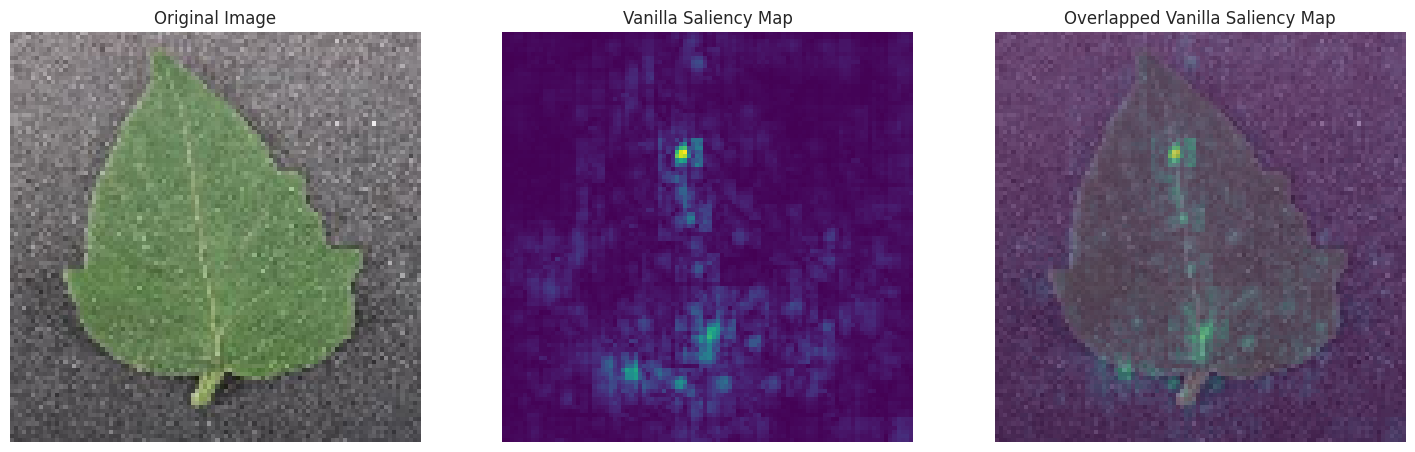

In [ ]:
plt.rcParams['figure.figsize'] = [18, 12]
tf.keras.utils.set_random_seed(1)

#Random element from test-set
test_example = test.batch(1).shuffle(1000).take(1)
for example in test_example:
    img = example[0]
    label = example[1]

#Image showing
plt.subplot(1, 3, 1)
plt.imshow(img[0])
plt.title('Original Image')
plt.axis('off')


#Gradient computation
with tf.GradientTape() as tape:
    tape.watch(img)
    out = model(img, training = False)
    #score assigned from the NN to the predicted class
    score = out[0, tf.argmax(out, axis = 1)[0]]

gradients = tf.abs(tape.gradient(score, img))

#We now sum the absolute values of the computed gradients for all the three dimensions of the image
v_saliency_map = gradients[0, :, :, 0] + gradients[0, :, :, 1] + gradients[0, :, :, 2]

#Saliency map showing
plt.subplot(1, 3, 2)
plt.imshow(v_saliency_map, cmap = 'viridis')
plt.title('Vanilla Saliency Map')
plt.axis('off')

#Overlapping in order to see the effectiveness of our saliency map
plt.subplot(1, 3, 3)
plt.imshow(img[0], cmap = 'binary')
plt.imshow(v_saliency_map, cmap = 'viridis', alpha = 0.5)
plt.title('Overlapped Vanilla Saliency Map')
plt.axis('off')
plt.show()

The regions that are brighter are the ones that have higher values in the saliency map, and are considered the most important for the prediction of the model. These areas contributed the most to the model decision.

From the saliency map we can see that the parts of the leaf that most influenced the final result are the leaf venis, the contour and the petiole.

By the way, that there is an evident amount of noise.

### Exercise 3: Advanced saliency maps  


Saliency maps have several issues: most notably, they suffer from noise and they are not stable to small changes in the input or in the model (try running again the training and interpreting the same point). Many methods have been proposed to overcome this.

**[SmoothGrad](https://arxiv.org/abs/1706.03825)**, for example, computes multiple saliency maps from noisy versions of the input:

$$
  \text{SmoothGrad}(x) = \frac{1}{n}\sum_{i=1}^n S(x + \varepsilon_i), \;\; \varepsilon_i \sim \mathcal{N}(0, \sigma^2I)
$$

where $\varepsilon$ is a vector of the same shape as $x$, whose values are sampled from a normal distribution with zero mean and small variance.



Instead of using a foor-loop where I compute the gradient for $N$ different tensors, I directly use an input that is a tensor with $shape = (N, 100, 100, 3)$, containing all the $N$ noised-images. Then, I average the gradients with $\texttt{reduce_mean}$ function from TensorFlow.

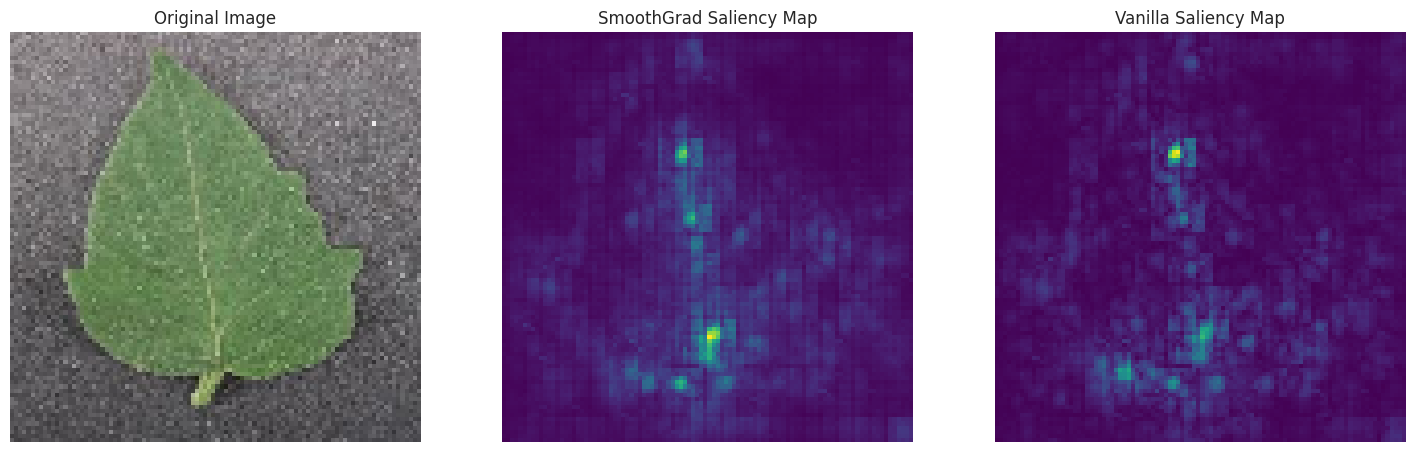

In [ ]:
tf.keras.utils.set_random_seed(1)

#Image showing
plt.subplot(1, 3, 1)
plt.imshow(img[0])
plt.title('Original Image')
plt.axis('off')

N = 30

#Noise Level = 1.85%
min_img = tf.reduce_min(img)
max_img = tf.reduce_max(img)
sd = 0.025 * (max_img - min_img)

#In order to avoid for loop, i pass a group of N samples to the model and average over them
noised_images = img + tf.random.normal([N] + list(img[0].shape), 0, sd)

with tf.GradientTape() as tape:
  tape.watch(noised_images)
  out = model(noised_images, training = False)
  #scores assigned from the NN to the predicted classes
  score = tf.convert_to_tensor([tf.reduce_max(j, axis = 0) for j in out])

#Then I average the gradients
gradients = tf.reduce_mean(tf.abs(tape.gradient(score, noised_images)), axis = 0)

sg_saliency_map = gradients[:, :, 0] + gradients[:, :, 1] + gradients[:, :, 2]

#SmoothGrad saliency map showing
plt.subplot(1, 3, 2)
plt.imshow(sg_saliency_map, cmap = 'viridis')
plt.title('SmoothGrad Saliency Map')
plt.axis('off')

#Vanilla saliency map
plt.subplot(1, 3, 3)
plt.imshow(v_saliency_map, cmap = 'viridis')
plt.title('Vanilla Saliency Map')
plt.axis('off')
plt.show()

From the SmoothGrad Saliency Map, we can see an improvement in the result. The points that mostly influenced  the model have a shape that is more clear than the Vanilla ones, and more similar to the effective leaf.

###  Global explanations

The previous exercises are examples of **local** explanations, where we try to interpret a single prediction of the network. Sometimes we are interested in **global** explanations, that try to find common patterns of behaviour. Suppose we have a dataset $\mathcal{T} = \left\{x_i\right\}$ of examples, we can compute some approximate global measure of influence by averaging their saliency:

$$
\text{GlobalSaliency} = \frac{1}{n} \sum_i S(x_i)
$$

To make this exercise more interesting, we will split it into 3 parts.



In [ ]:
n = 150
tf.keras.utils.set_random_seed(222)
test_example = test.batch(1).shuffle(300).take(n)

def saliency_function(test_example):
  jacobians = []

  examples = []
  labelss = []
  for example in test_example:
    examples.append(example[0])
    labelss.append(example[1])

  #Concatenating all the selected images in a tf object
  images = tf.keras.layers.Concatenate(axis=0)(examples)
  labels = tf.keras.layers.Concatenate(axis=0)(labelss)

  with tf.GradientTape() as tape:
    tape.watch(images)
    out = model(images)
    #scores assigned from the NN to the predicted classes
    scores = tf.convert_to_tensor([tf.reduce_max(j, axis = 0) for j in out])

  #Given that I apply multiple times the BatchNormalization, using batch_jacobian function would be useless
  #because I remove the independence among the different elements of the batch
  S = tape.gradient(scores, images)
  return S

S1 = saliency_function(test_example)
print(f"The dimension of the output is: {S1.shape}")

The dimension of the output is: (150, 100, 100, 3)


**Exercise 4.2**: write a function to compute the global saliency and try to explain the results.

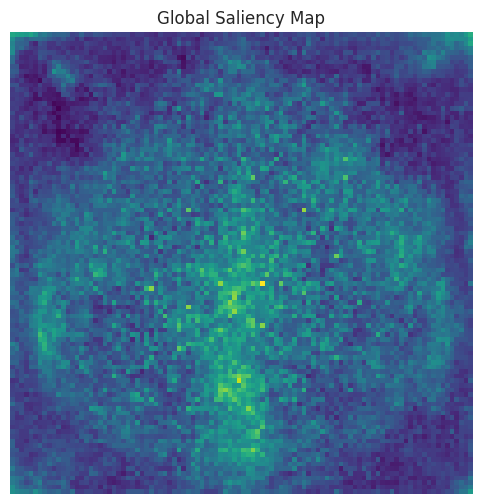

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]

def global_saliency(S):
  S = tf.abs(S)
  return tf.reduce_mean(S, axis = 0)

GlobalSaliency = global_saliency(S1)
global_saliency_map = GlobalSaliency[:, :, 0] + GlobalSaliency[:, :, 1] + GlobalSaliency[:, :, 2]

plt.imshow(global_saliency_map, cmap = 'viridis')
plt.title('Global Saliency Map')
plt.axis('off')
plt.show()

The result is very satisfying: we can see that the global saliency map represents "approximately" a leaf.

This map offers a detailed look at the most relevant and discriminating traits of the different leaves, allowing to identify their "common traits" with good precision.

## Comparison with a Linear Model

Note that a linear model $f(x) = w^\top x + b$ is an example of an *intrinsically* interpretable  model, since the weights $w$ can be checked to analyze the global saliency of each feature (see [3]).

In [ ]:
linear_model = keras.models.Sequential([keras.layers.Flatten(input_shape = (100, 100, 3)),
                                       keras.layers.Dense(38, activation = 'softmax')])

linear_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
linear_model.fit(train, epochs = 20, batch_size = 16, validation_data = val)

Epoch 1/20
2376/2376 [==============================] - 53s 22ms/step - loss: 6.8230 - accuracy: 0.3625 - val_loss: 7.7695 - val_accuracy: 0.4236
Epoch 2/20
2376/2376 [==============================] - 32s 13ms/step - loss: 6.5883 - accuracy: 0.4562 - val_loss: 7.1348 - val_accuracy: 0.4171
Epoch 3/20
2376/2376 [==============================] - 31s 13ms/step - loss: 6.4265 - accuracy: 0.4942 - val_loss: 8.1276 - val_accuracy: 0.4667
Epoch 4/20
2376/2376 [==============================] - 30s 13ms/step - loss: 6.1573 - accuracy: 0.5205 - val_loss: 7.6809 - val_accuracy: 0.4696
Epoch 5/20
2376/2376 [==============================] - 31s 13ms/step - loss: 6.0072 - accuracy: 0.5430 - val_loss: 7.4252 - val_accuracy: 0.5492
Epoch 6/20
2376/2376 [==============================] - 31s 13ms/step - loss: 5.9213 - accuracy: 0.5544 - val_loss: 7.9888 - val_accuracy: 0.5208
Epoch 7/20
2376/2376 [==============================] - 30s 13ms/step - loss: 5.5576 - accuracy: 0.5738 - val_loss: 5.8981 -

In [ ]:
tf.keras.utils.set_random_seed(222)

n = 150
test_example = test.batch(1).shuffle(200).take(n)

def saliency_function_linear(test_example):
  jacobians = []

  examples = []
  labelss = []
  for example in test_example:
    examples.append(example[0])
    labelss.append(example[1])


  images = tf.keras.layers.Concatenate(axis=0)(examples)
  labels = tf.keras.layers.Concatenate(axis=0)(labelss)

  with tf.GradientTape() as tape:
    tape.watch(images)
    out = linear_model(images)
    scores = tf.convert_to_tensor([tf.reduce_max(j, axis = 0) for j in out])

  #Given that I apply multiple times the BatchNormalization, using batch_jacobian function would be useless
  #cause I remove the independence among the different elements of the batch
  S = tape.gradient(scores, images)
  return S

S1_linear = saliency_function_linear(test_example)
print(f"The dimension of the output is: {S1_linear.shape}")

The dimension of the output is: (150, 100, 100, 3)


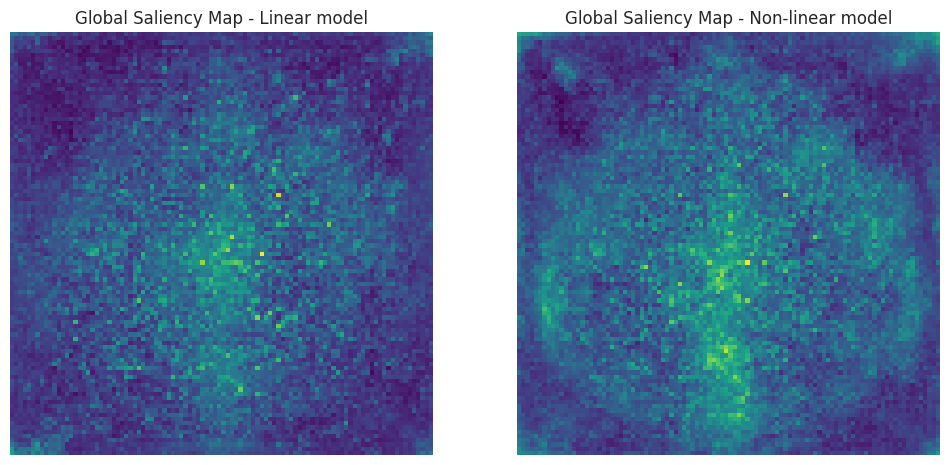

In [ ]:
def global_saliency_lin(S):
  S = tf.abs(S)
  return tf.reduce_mean(S, axis = 0)

GlobalSaliency = global_saliency_lin(S1_linear)
global_saliency_map_lin = GlobalSaliency[:, :, 0] + GlobalSaliency[:, :, 1] + GlobalSaliency[:, :, 2]


plt.subplot(1, 2, 1)
plt.imshow(global_saliency_map_lin, cmap = 'viridis')
plt.title('Global Saliency Map - Linear model')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(global_saliency_map, cmap = 'viridis')
plt.title('Global Saliency Map - Non-linear model')
plt.axis('off')
plt.show()

The new saliency map seems less precise than the previous one. The shape looks like a leaf, but it's not well defined like the one generated by the DenseNet-121.

This is most likely caused by the fact that linear models are straightforward models that function by assigning linear weight combinations to the input features. The global saliency map may become less defined as a result of the restricted capacity to seize correlations between features.

Alternatively, DenseNet-121 model enables the layers (convolutional and dense) to acquire richer input data representations and more intricate feature hierarchies. \\
Given that DenseNet is able to seize more complex  correlations between features, it is also able to build saliency maps that are more precisely defined.

### Bibliography

[1] Simonyan, K., Vedaldi, A. and Zisserman, A., 2013. [Deep inside convolutional networks: Visualising image classification models and saliency maps](https://arxiv.org/abs/1312.6034). arXiv preprint arXiv:1312.6034.

[2] Smilkov, D., Thorat, N., Kim, B., Viégas, F. and Wattenberg, M., 2017. [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825). arXiv preprint arXiv:1706.03825.

[3] Rudin, C., 2019. [Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead](https://www.nature.com/articles/s42256-019-0048-x). Nature Machine Intelligence, 1(5), pp. 206-215.

[4] Nguyen, G., Kim, D. and Nguyen, A., 2021. [The effectiveness of feature attribution methods and its correlation with automatic evaluation scores](https://proceedings.neurips.cc/paper/2021/hash/de043a5e421240eb846da8effe472ff1-Abstract.html). Advances in Neural Information Processing Systems, 34, pp.26422-26436.

[5] Pruthi, G., Liu, F., Kale, S. and Sundararajan, M., 2020. [Estimating training data influence by tracing gradient descent](https://proceedings.neurips.cc/paper/2020/hash/e6385d39ec9394f2f3a354d9d2b88eec-Abstract.html). Advances in Neural Information Processing Systems, 33, pp. 19920-19930.